아래의 코드는 주어진 Moving Boundary를 활용하는 예제입니다.

다음과 같은 단계로 이루어져 있습니다:

> 1. 필요한 라이브러리와 사용자 정의 모듈을 불러옵니다.

> 2. 데이터 파일 경로를 설정합니다.

> 3. 결과를 저장하기 위한 함수를 정의합니다.

> 4. 훈련 데이터와 테스트 데이터를 불러옵니다.

> 5. 훈련 데이터를 사용하여 Configuration을 계산하고 저장합니다.

> 6. 시험용 데이터를 사용하여 Boundary Monitoring을 실행합니다.

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm

# 상위 디렉토리로 경로를 설정합니다.
sys.path.append(os.path.abspath('../'))

# 사용자 정의 모듈을 불러옵니다.
from classify_fault.set_config import *
from classify_fault.check_boundary import *

In [2]:
data_path = '../data/TemperatureTrain.csv'
data_path2 = '../data/Temperature.csv'
config_save_path = '../config/example_config.json'

In [3]:
# 훈련 데이터와 테스트 데이터를 불러옵니다.
train_data = pd.read_csv(data_path, index_col=[0])
test_data = pd.read_csv(data_path2, index_col=[0])
tag_list = train_data.columns.to_list()
test_tag_list = ['temp5Bias']

In [4]:
train_data[tag_list].head()

,temp5
DateTime,
2022-08-01 00:00:00,1220.54
2022-08-01 00:10:00,1210.31
2022-08-01 00:20:00,1206.14
2022-08-01 00:30:00,1200.39
2022-08-01 00:40:00,1204.22


In [5]:
test_data[test_tag_list].head()

,temp5Bias
DateTime,
2023-01-01 00:00:00,1192.58
2023-01-01 00:01:00,1193.04
2023-01-01 00:02:00,1193.46
2023-01-01 00:03:00,1192.96
2023-01-01 00:04:00,1190.98


In [6]:
# 훈련 데이터를 사용하여 Configuration을 계산합니다.
config = calculate_variables_config(tag_list=tag_list, data=train_data[tag_list].values)
save_config(data=config, json_file_path='../config/example_config.json')
average = config[tag_list[0]]['statistic']['mean']
stdev = config[tag_list[0]]['statistic']['std']
tracking_size = config[tag_list[0]]["tracking_size"]

In [7]:
# 시험용 데이터를 사용하여 Univariate Monitoring을 실행합니다.
detecteds = []  # 경계 초과 결과에 대한 리스트
boundarys = []
means = []
moving_boundary_plus = []
moving_boundary_minus = []

# 트래킹 사이즈부터 테스트 데이터의 끝까지 반복
for i in tqdm(range(tracking_size, len(test_data))):
# for i in (range(int(len(test_data)*0.7), len(test_data))):
    config = load_config(json_file_path='../config/example_config.json')
    test_ = test_data[test_tag_list].values[i-tracking_size: i, :].ravel()    # make 1d array

    ref_ = [average for _ in range(len(test_))]

    origin_value = test_data[test_tag_list].values[i][0]
    high, low = config[tag_list[0]]['boundary_limits']['high'], config[tag_list[0]]['boundary_limits']['low']
    # 경계 밖 데이터를 감지하는 함수를 호출하고 결과를 저장합니다.
    result = detect_out_of_bounds(x=float(test_[-1]), high=float(high), low=float(low))
    # result = {'success': False, 'result': [True, 9.0]}
    # 결과값을 저장합니다.
    detecteds.append(result['result'][0])
    boundarys.append(result['result'][1])
    statistic_update, boundary_limits = {}, {}
    statistic = config[tag_list[0]]['statistic']

    set_boundary_res = set_boundary(statistics=statistic,
                                    x=test_[-1], boundary_type='moving')['result']
    boundary_limits['high'], boundary_limits['low'], statistic_update['mean'], statistic_update['std'] = set_boundary_res
    statistic_update['max'], statistic_update['min'] = max((max(test_)), statistic['max']), min(min(test_), statistic['min'])
    statistic_update['oldest_value'] = test_[0]
    
    means.append(statistic_update['mean'])
    moving_boundary_plus.append(boundary_limits['high'])
    moving_boundary_minus.append(boundary_limits['low'])

    # update configuration
    update_config(config_path='../config/example_config.json',
                  tag=tag_list[0], 
                  statistic=statistic_update,
                  boundary_limits=boundary_limits)
    

100%|██████████| 52747/52747 [02:47<00:00, 315.58it/s]


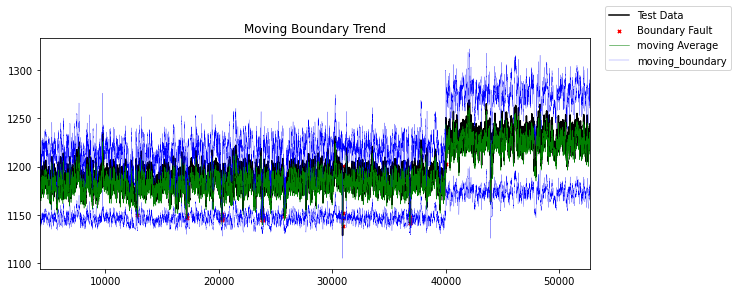

In [9]:
# 시각화
import matplotlib.pyplot as plt
test_data_list = list(test_data[test_tag_list].values.flatten())
detecteds = [t if d else None for t, d in zip(test_data_list, detecteds)]

fig, ax = plt.subplots(1,1, figsize=(9, 4), sharex=True)
ax1 = ax
# ax12 = ax1.twinx()

ax1.plot(test_data_list[:len(detecteds)], c='k', label='Test Data')
ax1.scatter(x=np.arange(len(detecteds)), y=detecteds, 
            s=10.5, c='r', marker='x',
            label='Boundary Fault')
ax1.plot(means, c='g', label='moving Average', linewidth=0.5)
ax1.set_xlim(int(len(detecteds) * 0.080), len(detecteds))

ax1.plot(moving_boundary_minus, c='b', linewidth=0.2)
ax1.plot(moving_boundary_plus, c='b', label='moving_boundary', linewidth=0.2)
ax1.set_title("Moving Boundary Trend")

fig.legend(loc='center', bbox_to_anchor=(1.07, 0.9))  # Set the legend location
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.95, hspace=0.4)
plt.show();